## Datasets used:

1. [The NASA exoplanet archive](https://exoplanetarchive.ipac.caltech.edu/cgi-bin/TblView/nph-tblView?app=ExoTbls&config=planets)
2. [The Planetary Habitability Laboratory (PHL) optimistic and conservative samples of potentially habitable planets]( http://phl.upr.edu/projects/habitable-exoplanets-catalog/data/database)


## Visualising the Dataset



In [ ]:
%matplotlib inline
import pandas as pd
import missingno as mn
import matplotlib.pyplot as plt
from matplotlib.markers import MarkerStyle


# import the data
#NASA exoplanets data 
!curl -s https://raw.githubusercontent.com/NeilBotelho/YSP-Exoplanets/master/TrainingModels/exoplanets.csv > exoplanets.csv
exos=pd.read_csv('exoplanets.csv')

missing={}
for n in exos.columns:
    missing[n]=exos[n].isnull().sum()/len(exos)
x=[x[0] for x in sorted(missing.items(), key = lambda kv:(kv[1]))]
y=[missing[val]*100 for val in x]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in long_scalars
  from ipykernel import kernelapp as app


### Number of Missing Data points in each column



Here the X axis represents the columns in the dataset, sorted by number of missing values in ascending order
The Y axis represents the number of missing values

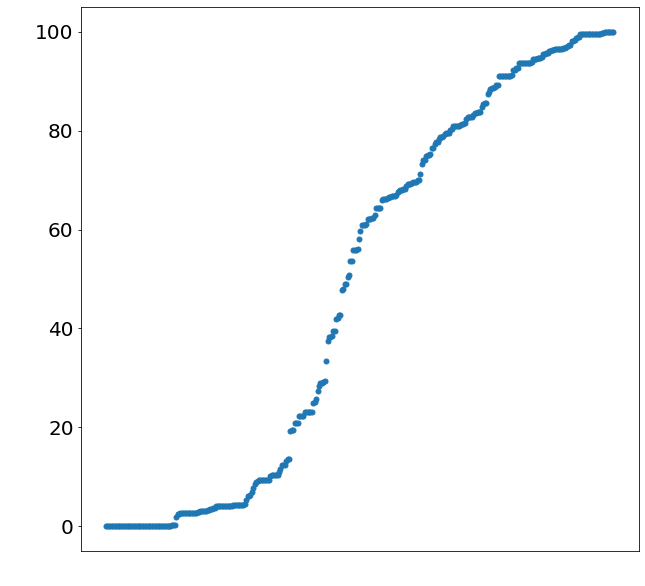

In [ ]:

plt.figure(figsize=(10,10))
plt.xticks([])
plt.yticks(fontsize=20)
plt.xlabel("Sorted Columns",fontsize=25,color='w')
plt.ylabel("Missing Percentage",fontsize=25,color='w')
plt.scatter(x,y,s=25)

### Representation of data from column 1 to 150

Here the columns represent the columns in the NASA exoplanets data with each horizontal black line representing a data point that is present and the white indicating missing data


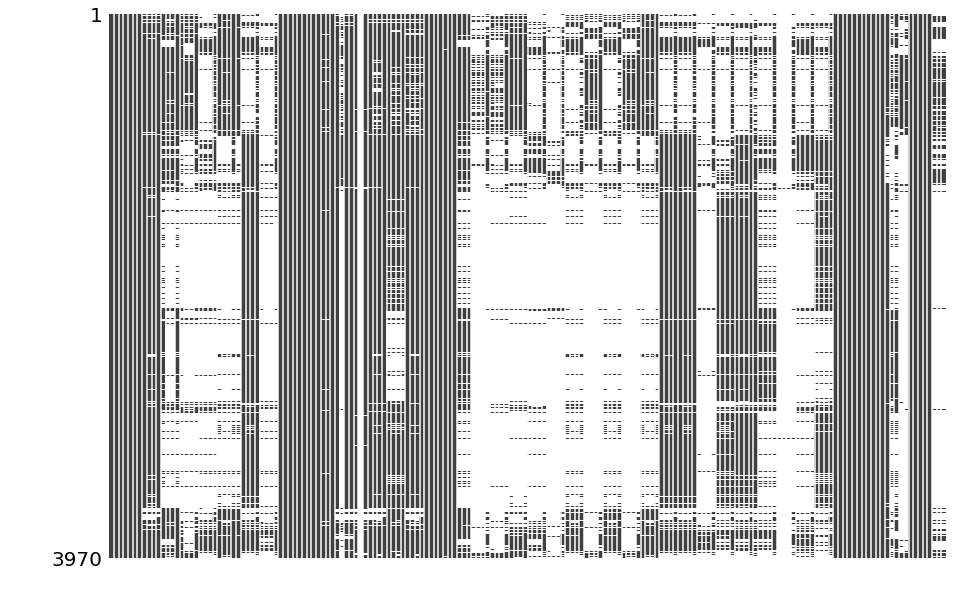

In [ ]:
mn.matrix(exos[exos.columns[:int(len(exos.columns)/2)]],figsize=(15,10),sparkline=False)
plt.ylabel("row number",fontsize=40,color='w')
plt.xlabel("column",fontsize=40,color='w')
plt.show()

### Representation of data from column number 151 to 356
Here the columns represent the columns in the NASA exoplanets data with each horizontal black line representing a data point that is present and the white indicating missing data



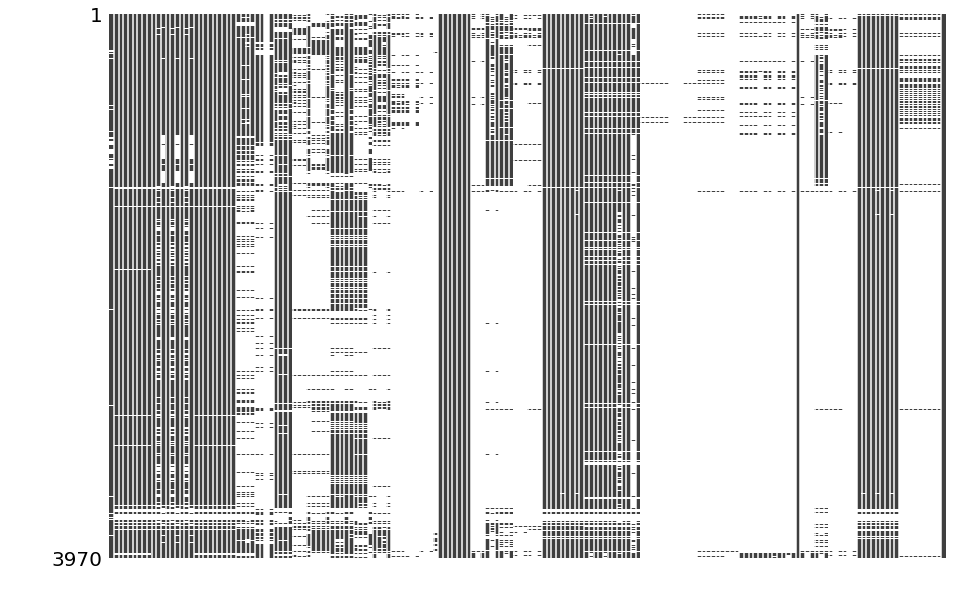

In [ ]:
mn.matrix(exos[exos.columns[int(len(exos.columns)/2):]],figsize=(15,10),sparkline=False)
plt.ylabel("row number",fontsize=40,color='w')
plt.xlabel("column",fontsize=40,color='w')
plt.show()

# To test the efficacy of various ML models in predicting whether a given exoplanet is habitable or not:

## Data Preprocessing:

As can be seen in the visualisations above, the NASA exoplanets archive has a significant amount of missing data, with some columns having more than 90% missing data. Hence the following methodology was used:



### Step 1
 Rather than simply discarding all rows with missing data, first all columns that had more than 40% missing data were removed, then, numerical columns from the dataset are imputed using the MICE library in R and then saved to the ImputedNumericalCols.csv file.
The R code used to impute the numerical columns can be found [here](https://github.com/NeilBotelho/YSP-Exoplanets/blob/master/TrainingModels/scripts/Impute.R)  


In [ ]:
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

# import the data

#PHL data 
hec_data = pd.read_csv("http://www.hpcf.upr.edu/~abel/phl/hec2/database/phl_exoplanet_catalog.csv")

#NASA exoplanets data 
!curl -s https://raw.githubusercontent.com/NeilBotelho/YSP-Exoplanets/master/TrainingModels/exoplanets.csv > exoplanets.csv
exos=pd.read_csv('exoplanets.csv')

# remove unconfirmed planets
hec_data = hec_data[hec_data.P_STATUS == 3].drop('P_STATUS', axis="columns")    # P_STATUS - planet status (confirmed = 3)

# leave only the habitable planets
hec_data = hec_data[hec_data.P_HABITABLE != 0]  # P_HABITABLE - planet is potentially habitable index  (1 = conservative, 2 = optimistic)

# join the data with the NASA exoplanets database to create a column that classifies if the planet is potentially habitable
habitable_planets_names = hec_data.P_NAME.values
exos["habitable"]  = exos['pl_name'].isin(habitable_planets_names)

#Read in the data we imputed using the MICE library in R
!curl -s https://raw.githubusercontent.com/NeilBotelho/YSP-Exoplanets/master/TrainingModels/ImputedNumericCols.csv > ImputedNumericCols.csv
imputedData=pd.read_csv('ImputedNumericCols.csv')

#Merge the imputed data and the exoplanets dataset
for n in imputedData.columns:
    if n not in exos.columns:
        pass
    else:
        exos[n]=imputedData[n]
#These columns may introduce bias in the model so remove them
remove=['pl_letter', 'pl_discmethod', 'pl_nnotes', 'ra_str', 'dec_str', 'rowupdate', 'pl_tsystemref', 'pl_def_reflink', 'pl_disc', 'pl_disc_reflink', 'pl_locale', 'pl_facility', 'pl_telescope', 'pl_instrument', 'pl_status', 'pl_pelink', 'st_nts', 'st_nplc', 'st_nglc', 'st_nrvc', 'st_naxa', 'st_nimg', 'st_nspec', 'st_photn', 'st_colorn', 'pl_hostname', 'pl_name', 'ra_str', 'dec_str', 'rowupdate', 'pl_def_reflink', 'pl_disc_reflink', 'pl_pelink', 'pl_edelink', 'pl_publ_date', 'hd_name', 'hip_name', 'st_spstr', 'swasp_id']

exos=exos.drop(remove,axis=1)

# remove columns with more the 40% missing data
def moreThan40Missing(col):
        numMissing=len(exos[exos[col].isnull()])
        if numMissing/len(exos)>0.4:
                return 1
        return 0
SignificantMissingData=[x for x in exos.columns if moreThan40Missing(x) ]
exos=exos.drop(SignificantMissingData,axis=1)

### Step 2
Any categorical columns with more than 10 unique values were removed and missing categorical data was replaced by the string “Missing”. The remaining categorical variables were one hot encoded. 

In [ ]:
Cat=[x for x in exos.columns if x not in exos._get_numeric_data().columns]
for n in Cat:
    if(len(exos[n].unique())>10):
        exos=exos.drop(n,axis=1)
Cat=[x for x in exos.columns if x not in exos._get_numeric_data().columns]

Following this procedure the resulting dataset, had significantly fewer missing data points, as can be seen in the figure below:

Text(0.5, 0, 'column')

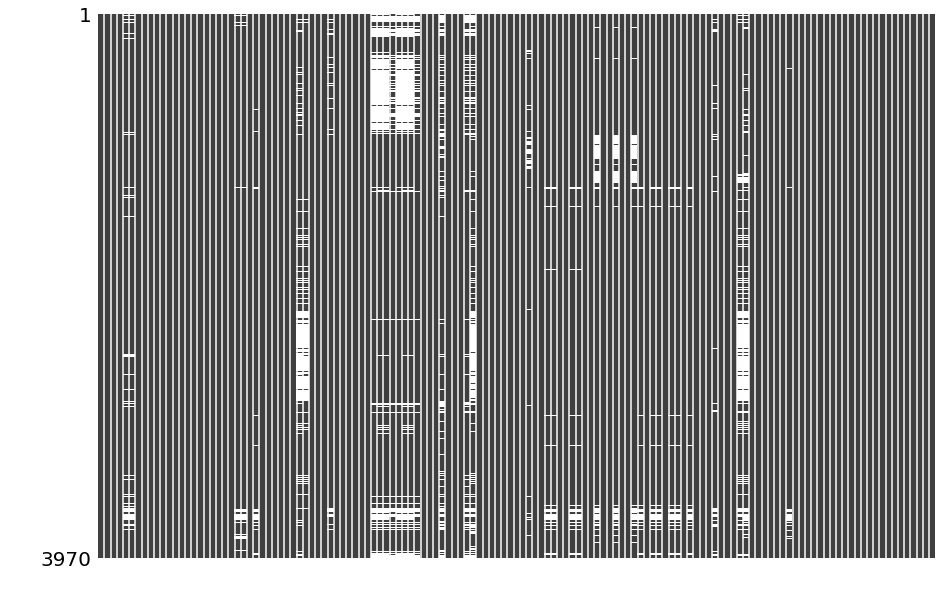

In [ ]:
mn.matrix(exos,figsize=(15,10),sparkline=False)
plt.ylabel("row number",fontsize=30,color='w')
plt.xlabel("column",fontsize=30,color='w')


### Step 3
As can be seen in the above figure, there is now significantly less missing data in the dataset. To handle the remaining missing data:
1. in categorical columns missing values are filled with the string 'missing'
2. in numerical columns, a simple imputer is used to fill the missing data with strategy of 'median'

Then the numerical data was scaled using scikit-learns Standard Scalar to scale each column to unit variance and remove the mean.  



In [ ]:
#Fill missing values with np.nan or "Missing"(if categorical)
for n in exos.columns:
    if(n in Cat):
        exos[n]=pd.Categorical(exos[n])
        exos[n]=exos[n].cat.add_categories("Missing").fillna("Missing")
    else:
        exos[n]=exos[n].fillna(np.nan)
exos=exos.set_index("rowid")

#Now we use a simple imputer to impute the remaining missing data.
#Simple imputers only work on numerical data so we only extract the numerical data from the exoplanets dataset
#Separate the habitable planets data from the dataset and impute the resulting two datasets using median imputation
habitable=exos[exos.habitable==True]
nonHabitable=exos[~exos.habitable==True]

imputer=SimpleImputer(missing_values=np.nan,strategy='median')
habitable[habitable._get_numeric_data().columns]=imputer.fit_transform(habitable[habitable._get_numeric_data().columns])
nonHabitable[nonHabitable._get_numeric_data().columns]=imputer.fit_transform(nonHabitable[nonHabitable._get_numeric_data().columns])


# Join the two datasets
tempExos=pd.concat([habitable,nonHabitable])

for n in tempExos.columns:
    if(n in exos.columns):
        exos[n]=tempExos[n]
    else:
        print(n)
#Scale the data so that it has unit variance
NumericCols=[]
for n in exos._get_numeric_data().columns:
	#Dont  scale binary columns(ie those that only have 1 or 0)
    if not (list(exos[n].unique())==[0,1]):
        NumericCols.append(n)
exos[NumericCols]=StandardScaler().fit_transform(exos[NumericCols])

#One hot encode categorical columns
preprocessed=pd.get_dummies(exos)

## Training Models


### Methodology
The exoplanets dataset is imbalanced, i.e. the number of positive samples(habitable) is far lower than the number of negative samples. This poses a problem when it comes to fitting and scoring a model. To counteract this problem the SMOTE oversampling method was used to artificially increase the number of positive samples. Half the available habitable exoplanets were assigned to the testing set and the other half were assigned to the training set. Which exoplanets were assigned to which set was determined randomly. 

Random exoplanets were then added to the testing set until it contained a total of 200 exoplanets. At this point SMOTE oversampling was used separately on the training set and testing set(to prevent contamination of training set with information from testing set) to give the final training and testing sets.

The hyperparameters were tuned using grid search

To score the model, scikit learn’s balanced accuracy score was used to account for the imbalanced nature of the dataset.



### Models Used:
The following machine learning models were fit on the dataset:
* Cat Boost Classifier
* Perceptron
* K-Neighbours Classifier 
* Random Forest Classifier
* SVC
* XGBoostClassifier

The accuracy of the above mentioned models varied slightly depending on what random seed was used to prepare the data passed to it, i.e. which habitable exoplanets were assigned to the testing set and which were assigned to the testing set (as habitable exoplanets were assigned randomly). Hence for every model mentioned above, the model was trained with data prepared at 5 different random seeds(42, 52, 62, 72 and 82) and the mean and median accuracy for each model was recorded. 

Additionally, the models were trained at 5 different random seeds, while keeping data the same to check that the model did not depend on random seed.


### Data Preparation



In [ ]:
import random as r
from sklearn.metrics import balanced_accuracy_score
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.linear_model import Perceptron
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split


/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


In [ ]:
habitableRows=list(preprocessed.rowid[preprocessed.habitable==True])

#The purpose of this function is to generate our train test split 
#Since its in the form of a function we can use it repeatedly while changing the random seed to get different train test splits
def prepareData():
    #List of columns to be used for training
    #it will be all columns in preprocessed except for "habitable" and "rowid"
    trainCols=[x for x in preprocessed.columns if x not in ['habitable','rowid']]
    validate=[]
    Hcopy=habitableRows.copy()
    #numHidden sets the number of habitable planets to use for validation of the model
    numHidden=round(len(Hcopy)/2)

    #Randomly select habitable exoplanets and 
    #add their row_id to validation set 
    print("Hiding ",numHidden," habitable(",end="")
    for i in range(numHidden): 
        randNum=r.randint(0,len(Hcopy)-1)  
        validate.append(Hcopy[randNum])
        print(Hcopy[randNum],end=",")
        del Hcopy[randNum]
    print("\b )")

    #Add row_id of non-habitable planets to the validation set till its length becomes 200
    while len(validate)<200:
        temp=r.randint(0,len(preprocessed)-1)
        if temp not in habitableRows and temp not in validate:
            validate.append(temp)

    #Take all columns of the planets whose row_id is in "validate" variable(in the validation set) and
    #store it in "validate" variable
    validate=preprocessed[preprocessed.rowid.isin(validate)]

    #Store the planets that are not in the validation set in the training set
    trainingSet=preprocessed[~preprocessed.rowid.isin(validate.rowid)]

    #Store the training features in X and target feature(habitable or not) in y 
    X=trainingSet[trainCols]
    y=trainingSet.habitable

    #the SMOTE library mutates existing data to creating more data
    #Here we use SMOTE to increase the number of habitable planets in the training and validation data
    smote = SMOTE(ratio='minority')
    X_sm, y_sm = smote.fit_sample(X, y)
    trainX, testX,trainY,testY=train_test_split(X_sm,y_sm)
    validateX,validateY=smote.fit_sample(validate[trainCols],validate.habitable)
    return trainX, testX,trainY,testY,validateX,validateY

### XGBoostClassifier

#### Effect of Random Seed on model
 Does changing the random seed during training but keeping the same dataset substantially change the outcome for this model?

In [ ]:
RandomSeed=42
Bestscores=[0,0]
trainX, testX,trainY,testY,validateX,validateY=prepareData()

max_depth=[3,5,7,10]
learning_rate=[1,0.1,0.01,0.001]
n_estimators=[10,50,100,150,200]
early_stopping_rounds=[3,5,10,20]
booster=["gbtree","dart"]
n_jobs=-1
loss_function=['Logloss','CrossEntropy','MultiClass', 'MultiClassOneVsAll' ]

for testNumber in range(5):
    print("*"*10,end="\n\n")
    print("TEST NUMBER",testNumber+1,"Random Seed =",RandomSeed)
    Bestscores=[0,0]
    r.seed(RandomSeed)
    RandomSeed=RandomSeed+10
    for l in learning_rate:
        for n in n_estimators:
            for b in [0,1]:
                for m in max_depth:
                    for early in early_stopping_rounds:
                        model=XGBClassifier(verbosity=0,max_depth=m,learning_rate=l,booster=booster[int(b)])
                        model.fit(trainX,trainY,eval_set=[(testX,testY)],early_stopping_rounds=early,verbose=False)
                        y_preds=model.predict(validateX)
                        currScore=balanced_accuracy_score(validateY,y_preds)
                        if(currScore>Bestscores[0]):
                            Bestscores[0]=currScore
                            Bestscores[1]=model.get_params()
    print("BEST SCORE:",str(Bestscores[0])+"\n"+"PARAMS:",Bestscores[1])


Hiding  24  habitable(128,2189,2316,2547,986,117,1424,1845,3115,3606,2097,2441,1205,3962,2031,153,2882,152,3743,1147,2902,2156,2883,2155, )
**********

TEST NUMBER 1 Random Seed = 42
BEST SCORE: 0.9261363636363635
PARAMS: {'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 1, 'gamma': 0, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 3, 'min_child_weight': 1, 'missing': None, 'n_estimators': 100, 'n_jobs': 1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'seed': None, 'silent': None, 'subsample': 1, 'verbosity': 0}
**********

TEST NUMBER 2 Random Seed = 52
BEST SCORE: 0.9261363636363635
PARAMS: {'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 1, 'gamma': 0, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 3, 'min_child_weight': 1, 'missing': None, 'n_estimators': 100, 'n_jobs': 

#### Conclusion 
Since changing random seed did not change the accuracy of the model (while keeping the data the same), We can conclude that the model does not depend on the random seed

#### Effect of changing random seed when preparing data on model

In [ ]:
RandomSeed=42
Bestscores=[0,0]
forCalc=[]
max_depth=[3,5,7,10]
learning_rate=[1,0.1,0.01,0.001]
n_estimators=[10,50,100,150,200]
early_stopping_rounds=[3,5,10,20]
booster=["gbtree","dart"]
n_jobs=-1
loss_function=['Logloss','CrossEntropy','MultiClass', 'MultiClassOneVsAll' ]

for testNumber in range(5):
    print("*"*10,end="\n\n")
    print("TEST NUMBER",testNumber+1,"Random Seed =",RandomSeed)
    Bestscores=[0,0]
    r.seed(RandomSeed)
    RandomSeed=RandomSeed+10
    trainX, testX,trainY,testY,validateX,validateY=prepareData()
    for l in learning_rate:
        for n in n_estimators:
            for b in [0,1]:
                for m in max_depth:
                    for early in early_stopping_rounds:
                        model=XGBClassifier(verbosity=0,max_depth=m,learning_rate=l,booster=booster[int(b)])
                        model.fit(trainX,trainY,eval_set=[(testX,testY)],early_stopping_rounds=early,verbose=False)
                        y_preds=model.predict(validateX)
                        currScore=balanced_accuracy_score(validateY,y_preds)
                        if(currScore>Bestscores[0]):
                            Bestscores[0]=currScore
                            Bestscores[1]=model.get_params()
    print("BEST SCORE:",str(Bestscores[0])+"\n"+"PARAMS:",Bestscores[1])
    forCalc.append(Bestscores[0])

**********

TEST NUMBER 1 Random Seed = 42
Hiding  24  habitable(3233,163,117,2031,2014,1845,1137,703,3716,153,3922,2883,130,128,1205,2156,2223,151,2542,1604,3133,3115,3741,2880, )
BEST SCORE: 0.9772727272727273
PARAMS: {'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 1, 'gamma': 0, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 3, 'min_child_weight': 1, 'missing': None, 'n_estimators': 100, 'n_jobs': 1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'seed': None, 'silent': None, 'subsample': 1, 'verbosity': 0}
**********

TEST NUMBER 2 Random Seed = 52
Hiding  24  habitable(2014,130,3962,2882,2547,2189,2503,128,1137,1227,2883,1604,2541,3233,114,152,3132,3742,117,1424,163,1205,1845,2542, )
BEST SCORE: 0.9346590909090909
PARAMS: {'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 1, 'gam

#### Result
* Mean Accuracy: 0.89375
* Median Accuracy: 0.9346590909090909
* Standard Deviation: 0.08040525583125309


### KNeighborsClassifier

#### Effect of Random Seed on model
 Does changing the random seed during training but keeping the same dataset substantially change the outcome for this model?

In [ ]:
RandomSeed=42
X_sm,y_sm,validateX,validateY=prepareData()
n_neighbours=[1,2,5,7]
algorithm=['auto','ball_tree','kd_tree','brute']
leaf_size=[10,20,30,40]
p=[1,2,5]
for testNumber in range(5):
    print("*"*10,end="\n\n")
    print("TEST NUMBER",testNumber+1,"Random Seed =",RandomSeed)
    r.seed(RandomSeed)
    RandomSeed=RandomSeed+10
    Bestscores=[0,0]
    for n in n_neighbours:
        for a in algorithm:
            for l in leaf_size:
                for P in p:
                    model=KNeighborsClassifier(n_neighbors=n,algorithm=a,leaf_size=l,p=P)
                    model.fit(X_sm,y_sm)
                    y_preds=model.predict(validateX)
                    currScore=balanced_accuracy_score(validateY,y_preds)
                    if(currScore>Bestscores[0]):
                        Bestscores[0]=currScore
                        Bestscores[1]=model.get_params()
    print("BEST SCORE:",str(Bestscores[0])+"\n"+"PARAMS:",Bestscores[1])

Hiding  24  habitable(2883,3716,3132,1604,2882,2129,2156,3741,3742,1845,151,1137,2155,2189,2316,1147,3115,1205,2014,130,1227,114,2547,2223, )
**********

TEST NUMBER 1 Random Seed = 42
BEST SCORE: 0.8039772727272727
PARAMS: {'algorithm': 'auto', 'leaf_size': 10, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': None, 'n_neighbors': 7, 'p': 5, 'weights': 'uniform'}
**********

TEST NUMBER 2 Random Seed = 52
BEST SCORE: 0.8039772727272727
PARAMS: {'algorithm': 'auto', 'leaf_size': 10, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': None, 'n_neighbors': 7, 'p': 5, 'weights': 'uniform'}
**********

TEST NUMBER 3 Random Seed = 62
BEST SCORE: 0.8039772727272727
PARAMS: {'algorithm': 'auto', 'leaf_size': 10, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': None, 'n_neighbors': 7, 'p': 5, 'weights': 'uniform'}
**********

TEST NUMBER 4 Random Seed = 72
BEST SCORE: 0.8039772727272727
PARAMS: {'algorithm': 'auto', 'leaf_size': 10, 'metric': 'minkowski', 'metric_params': Non

#### Conclusion 
Since changing random seed did not change the accuracy of the model (while keeping the data the same), We can conclude that the model does not depend on the random seed.

#### Effect of changing random seed when preparing data on model

In [ ]:
RandomSeed=42
n_neighbours=[1,2,5,7]
algorithm=['auto','ball_tree','kd_tree','brute']
leaf_size=[10,20,30,40]
p=[1,2,5]
for testNumber in range(5):
    print("*"*10,end="\n\n")
    print("TEST NUMBER",testNumber+1,"Random Seed =",RandomSeed)
    r.seed(RandomSeed)
    X_sm,y_sm,validateX,validateY=prepareData()
    RandomSeed=RandomSeed+10
    Bestscores=[0,0]
    for n in n_neighbours:
        for a in algorithm:
            for l in leaf_size:
                for P in p:
                    model=KNeighborsClassifier(n_neighbors=n,algorithm=a,leaf_size=l,p=P)
                    model.fit(X_sm,y_sm)
                    y_preds=model.predict(validateX)
                    currScore=balanced_accuracy_score(validateY,y_preds)
                    if(currScore>Bestscores[0]):
                        Bestscores[0]=currScore
                        Bestscores[1]=model.get_params()
    print("BEST SCORE:",str(Bestscores[0])+"\n"+"PARAMS:",Bestscores[1])

**********

TEST NUMBER 1 Random Seed = 42
Hiding  24  habitable(3233,163,117,2031,2014,1845,1137,703,3716,153,3922,2883,130,128,1205,2156,2223,151,2542,1604,3133,3115,3741,2880, )
BEST SCORE: 0.7869318181818181
PARAMS: {'algorithm': 'auto', 'leaf_size': 10, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': None, 'n_neighbors': 7, 'p': 5, 'weights': 'uniform'}
**********

TEST NUMBER 2 Random Seed = 52
Hiding  24  habitable(2014,130,3962,2882,2547,2189,2503,128,1137,1227,2883,1604,2541,3233,114,152,3132,3742,117,1424,163,1205,1845,2542, )
BEST SCORE: 0.7471590909090909
PARAMS: {'algorithm': 'auto', 'leaf_size': 10, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': None, 'n_neighbors': 7, 'p': 2, 'weights': 'uniform'}
**********

TEST NUMBER 3 Random Seed = 62
Hiding  24  habitable(2902,1147,151,2014,2547,2135,3962,2223,1205,3233,1424,1227,114,2156,1845,986,128,3744,2441,2541,117,3741,2129,3115, )
BEST SCORE: 0.7244318181818181
PARAMS: {'algorithm': 'auto', 'leaf_size': 1

#### Result
* Mean Accuracy: 0.7488636363636364
* Median Accuracy: 0.7471590909090909
* Standard Deviation: 0.020767803275564836 


### Perceptron

#### Effect of Random Seed on model
 Does changing the random seed during training but keeping the same dataset substantially change the outcome for this model?

In [ ]:
RandomSeed=42
X_sm,y_sm,validateX,validateY=prepareData()
penalty=[None, 'l2' , 'elasticnet']
alpha=[ 1,0.1,0.01, 0.001]
max_iter=[500,1000,2000]
tol=[0.00001,0.0001,0.001,0.01]
n_iter_no_change=[10,13,20]
eta0=[1,10,20,50,100,200]
for testNumber in range(5):
    print("*"*10,end="\n\n")
    print("TEST NUMBER",testNumber+1,"Random Seed =",RandomSeed)
    r.seed(RandomSeed)
    RandomSeed=RandomSeed+10
    Bestscores=[0,0]
    for p in penalty:
        for a in alpha:
            for m in max_iter:
                for t in tol:
                    for e in eta0:
                        for n in n_iter_no_change:
                                model= Perceptron(penalty=p,alpha=a,tol=t,n_iter_no_change=n,max_iter=m,n_jobs=-1,early_stopping=True,eta0=e)
                                model.fit(X_sm,y_sm)
                                y_preds=model.predict(validateX)
                                currScore=balanced_accuracy_score(validateY,y_preds)
                                if(currScore>Bestscores[0]):
                                    Bestscores[0]=currScore
                                    Bestscores[1]=model.get_params()
    print("BEST SCORE:",str(Bestscores[0])+"\n"+"PARAMS:",Bestscores[1])

Hiding  24  habitable(2129,128,1227,3742,3606,151,3115,1845,2316,3744,1205,1424,2156,2547,3132,2902,2031,3133,2882,1604,2155,2541,986,163, )
**********

TEST NUMBER 1 Random Seed = 42
BEST SCORE: 0.8835227272727273
PARAMS: {'alpha': 0.001, 'class_weight': None, 'early_stopping': True, 'eta0': 1, 'fit_intercept': True, 'max_iter': 500, 'n_iter_no_change': 10, 'n_jobs': -1, 'penalty': 'l2', 'random_state': 0, 'shuffle': True, 'tol': 1e-05, 'validation_fraction': 0.1, 'verbose': 0, 'warm_start': False}
**********

TEST NUMBER 2 Random Seed = 52
BEST SCORE: 0.8835227272727273
PARAMS: {'alpha': 0.001, 'class_weight': None, 'early_stopping': True, 'eta0': 1, 'fit_intercept': True, 'max_iter': 500, 'n_iter_no_change': 10, 'n_jobs': -1, 'penalty': 'l2', 'random_state': 0, 'shuffle': True, 'tol': 1e-05, 'validation_fraction': 0.1, 'verbose': 0, 'warm_start': False}
**********

TEST NUMBER 3 Random Seed = 62
BEST SCORE: 0.8835227272727273
PARAMS: {'alpha': 0.001, 'class_weight': None, 'early_st

#### Conclusion 
Since changing random seed did not change the accuracy of the model (while keeping the data the same), We can conclude that the model does not depend on the random seed

#### Effect of changing random seed when preparing data on model

In [ ]:
RandomSeed=42
penalty=[None, 'l2' , 'elasticnet']
alpha=[ 1,0.1,0.01, 0.001]
max_iter=[500,1000,2000]
tol=[0.00001,0.0001,0.001,0.01]
n_iter_no_change=[10,13,20]
eta0=[1,10,20,50,100,200]
for testNumber in range(5):
    print("*"*10,end="\n\n")
    print("TEST NUMBER",testNumber,"Random Seed =",RandomSeed)
    r.seed(RandomSeed)
    RandomSeed=RandomSeed+10
    X_sm,y_sm,validateX,validateY=prepareData()
    Bestscores=[0,0]
    for p in penalty:
        for a in alpha:
            for m in max_iter:
                for t in tol:
                    for e in eta0:
                        for n in n_iter_no_change:
                                model= Perceptron(penalty=p,alpha=a,tol=t,n_iter_no_change=n,max_iter=m,n_jobs=-1,early_stopping=True,eta0=e)
                                model.fit(X_sm,y_sm)
                                y_preds=model.predict(validateX)
                                currScore=balanced_accuracy_score(validateY,y_preds)
                                if(currScore>Bestscores[0]):
                                    Bestscores[0]=currScore
                                    Bestscores[1]=model.get_params()
    print("BEST SCORE:",str(Bestscores[0])+"\n"+"PARAMS:",Bestscores[1])

**********

TEST NUMBER 0 Random Seed = 42
Hiding  24  habitable(3233,163,117,2031,2014,1845,1137,703,3716,153,3922,2883,130,128,1205,2156,2223,151,2542,1604,3133,3115,3741,2880, )
BEST SCORE: 0.8607954545454546
PARAMS: {'alpha': 0.001, 'class_weight': None, 'early_stopping': True, 'eta0': 50, 'fit_intercept': True, 'max_iter': 500, 'n_iter_no_change': 13, 'n_jobs': -1, 'penalty': 'l2', 'random_state': 0, 'shuffle': True, 'tol': 1e-05, 'validation_fraction': 0.1, 'verbose': 0, 'warm_start': False}
**********

TEST NUMBER 1 Random Seed = 52
Hiding  24  habitable(2014,130,3962,2882,2547,2189,2503,128,1137,1227,2883,1604,2541,3233,114,152,3132,3742,117,1424,163,1205,1845,2542, )
BEST SCORE: 0.84375
PARAMS: {'alpha': 0.01, 'class_weight': None, 'early_stopping': True, 'eta0': 1, 'fit_intercept': True, 'max_iter': 500, 'n_iter_no_change': 13, 'n_jobs': -1, 'penalty': 'l2', 'random_state': 0, 'shuffle': True, 'tol': 1e-05, 'validation_fraction': 0.1, 'verbose': 0, 'warm_start': False}
****

#### Result
* Mean Accuracy: 0.8454545454545455
* Median Accuracy: 0.8494318181818182
* Standard Deviation: 0.013397529684717729


### SVC

#### Effect of Random Seed on model
 Does changing the random seed during training but keeping the same dataset substantially change the outcome for this model?

In [ ]:
RandomSeed=42
X_sm,y_sm,validateX,validateY=prepareData()
coef=[0,0.1,0.01,0.001]
degree=[1,2,3]
C =[1,0.1,0.01,0.001]
shrink=[True,False]
decision_shape=['ovo','ovr']
tol=[1,0.1,0.01,0.001]

for testNumber in range(5):
    print("*"*10,end="\n\n")
    print("TEST NUMBER",testNumber+1,"Random Seed =",RandomSeed)
    Bestscores=[0,0]
    r.seed(RandomSeed)
    RandomSeed=RandomSeed+10
    for c in C:
        for dec in decision_shape:
            for d in degree:
                for co in coef:
                    for t in tol:
                        for s in shrink:
                            model=SVC(C=c,coef0=co,tol=t,kernel='linear',degree=d,gamma='auto',shrinking=s,decision_function_shape=dec)
                            model.fit(X_sm,y_sm)
                            y_preds=model.predict(validateX)
                            currScore=balanced_accuracy_score(validateY,y_preds)
                            if(currScore>Bestscores[0]):
                                Bestscores[0]=currScore
                                Bestscores[1]=model.get_params()
    print("BEST SCORE:",str(Bestscores[0])+"\n"+"PARAMS:",Bestscores[1])                            



Hiding  24  habitable(2135,2156,703,2503,3606,117,2155,2031,2547,128,1604,986,1205,3922,2223,2883,2014,3743,152,114,130,1227,2882,1137, )
**********

TEST NUMBER 1 Random Seed = 42
BEST SCORE: 0.7556818181818181
PARAMS: {'C': 0.001, 'cache_size': 200, 'class_weight': None, 'coef0': 0, 'decision_function_shape': 'ovo', 'degree': 1, 'gamma': 'auto', 'kernel': 'linear', 'max_iter': -1, 'probability': False, 'random_state': None, 'shrinking': True, 'tol': 1, 'verbose': False}
**********

TEST NUMBER 2 Random Seed = 52
BEST SCORE: 0.7556818181818181
PARAMS: {'C': 0.001, 'cache_size': 200, 'class_weight': None, 'coef0': 0, 'decision_function_shape': 'ovo', 'degree': 1, 'gamma': 'auto', 'kernel': 'linear', 'max_iter': -1, 'probability': False, 'random_state': None, 'shrinking': True, 'tol': 1, 'verbose': False}
**********

TEST NUMBER 3 Random Seed = 62
BEST SCORE: 0.7556818181818181
PARAMS: {'C': 0.001, 'cache_size': 200, 'class_weight': None, 'coef0': 0, 'decision_function_shape': 'ovo', '

#### Conclusion 
Since changing random seed did not change the accuracy of the model (while keeping the data the same), We can conclude that the model does not depend on the random seed

#### Effect of changing random seed when preparing data on model

In [ ]:
RandomSeed=42
Bestscores=[0,0]
coef=[0,0.1,0.01,0.001]
degree=[1,2,3]
C =[1,0.1,0.01,0.001]
shrink=[True,False]
decision_shape=['ovo','ovr']
tol=[1,0.1,0.01,0.001]

for testNumber in range(5):
    print("*"*10,end="\n\n")
    print("TEST NUMBER",testNumber+1,"Random Seed =",RandomSeed)
    r.seed(RandomSeed)
    RandomSeed=RandomSeed+10
    X_sm,y_sm,validateX,validateY=prepareData()
    for c in C:
        for dec in decision_shape:
            for d in degree:
                for co in coef:
                    for t in tol:
                        for s in shrink:
                            model=SVC(C=c,coef0=co,tol=t,kernel='linear',degree=d,gamma='auto',shrinking=s,decision_function_shape=dec)
                            model.fit(X_sm,y_sm)
                            y_preds=model.predict(validateX)
                            currScore=balanced_accuracy_score(validateY,y_preds)
                            if(currScore>Bestscores[0]):
                                Bestscores[0]=currScore
                                Bestscores[1]=model.get_params()
    print("BEST SCORE:",str(Bestscores[0])+"\n"+"PARAMS:",Bestscores[1])                            



**********

TEST NUMBER 1 Random Seed = 42
Hiding  24  habitable(3233,163,117,2031,2014,1845,1137,703,3716,153,3922,2883,130,128,1205,2156,2223,151,2542,1604,3133,3115,3741,2880, )
BEST SCORE: 0.8238636363636364
PARAMS: {'C': 0.001, 'cache_size': 200, 'class_weight': None, 'coef0': 0, 'decision_function_shape': 'ovo', 'degree': 1, 'gamma': 'auto', 'kernel': 'linear', 'max_iter': -1, 'probability': False, 'random_state': None, 'shrinking': False, 'tol': 0.1, 'verbose': False}
**********

TEST NUMBER 2 Random Seed = 52
Hiding  24  habitable(2014,130,3962,2882,2547,2189,2503,128,1137,1227,2883,1604,2541,3233,114,152,3132,3742,117,1424,163,1205,1845,2542, )
BEST SCORE: 0.8238636363636364
PARAMS: {'C': 0.001, 'cache_size': 200, 'class_weight': None, 'coef0': 0, 'decision_function_shape': 'ovo', 'degree': 1, 'gamma': 'auto', 'kernel': 'linear', 'max_iter': -1, 'probability': False, 'random_state': None, 'shrinking': False, 'tol': 0.1, 'verbose': False}
**********

TEST NUMBER 3 Random Seed

#### Result
* Mean Accuracy: 0.8357954545454545
* Median Accuracy: 0.84375
* Standard Deviation: 0.009742288749705827

### RandomForestClassifier

#### Effect of Random Seed on model
 Does changing the random seed during training but keeping the same dataset substantially change the outcome for this model?

In [ ]:
RandomSeed=42
X_sm,y_sm,validateX,validateY=prepareData()
estimators=[x for x in range(1,100)]
criterion=['gini','entropy']
max_depth=[6,7,8,9]

for testNumber in range(5):
    print("*"*10,end="\n\n")
    print("TEST NUMBER",testNumber+1,"Random Seed =",RandomSeed)
    r.seed(RandomSeed)
    RandomSeed=RandomSeed+10
    Bestscores=[0,0]
    for e in estimators:
        for c in criterion:
            for m in max_depth:
                    model=RandomForestClassifier(n_estimators=e,max_depth=m,criterion=c,n_jobs=-1)
                    model.fit(X_sm,y_sm)
                    y_preds=model.predict(validateX)
                    currScore=balanced_accuracy_score(validateY,y_preds)
                    if(currScore>Bestscores[0]):
                        Bestscores[0]=currScore
                        Bestscores[1]=model.get_params()
    print("BEST SCORE:",str(Bestscores[0])+"\n"+"PARAMS:",Bestscores[1])

Hiding  24  habitable(3716,3233,2542,3115,2902,3133,3744,152,2223,3132,2547,2189,2503,986,1205,163,3606,1137,1227,2135,703,153,2541,2882, )
**********

TEST NUMBER 1 Random Seed = 42
BEST SCORE: 0.9090909090909092
PARAMS: {'bootstrap': True, 'class_weight': None, 'criterion': 'gini', 'max_depth': 6, 'max_features': 'auto', 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 7, 'n_jobs': -1, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}
**********

TEST NUMBER 2 Random Seed = 52
BEST SCORE: 0.9204545454545454
PARAMS: {'bootstrap': True, 'class_weight': None, 'criterion': 'gini', 'max_depth': 6, 'max_features': 'auto', 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 5, 'n_jobs': -1, 'oob_score': False, 'r

#### Conclusion 
Since changing random seed did not change the accuracy of the model (while keeping the data the same), We can conclude that the model does not depend on the random seed

#### Effect of changing random seed when preparing data on model

In [ ]:
RandomSeed=42
estimators=[x for x in range(1,100)]
criterion=['gini','entropy']
max_depth=[6,7,8,9]

for testNumber in range(5):
    print("*"*10,end="\n\n")
    print("TEST NUMBER",testNumber+1,"Random Seed =",RandomSeed)
    r.seed(RandomSeed)
    RandomSeed=RandomSeed+10
    X_sm,y_sm,validateX,validateY=prepareData()
    Bestscores=[0,0]
    for e in estimators:
        for c in criterion:
            for m in max_depth:
                    model=RandomForestClassifier(n_estimators=e,max_depth=m,criterion=c,n_jobs=-1)
                    model.fit(X_sm,y_sm)
                    y_preds=model.predict(validateX)
                    currScore=balanced_accuracy_score(validateY,y_preds)
                    if(currScore>Bestscores[0]):
                        Bestscores[0]=currScore
                        Bestscores[1]=model.get_params()
    print("BEST SCORE:",str(Bestscores[0])+"\n"+"PARAMS:",Bestscores[1])

**********

TEST NUMBER 1 Random Seed = 42
Hiding  24  habitable(3233,163,117,2031,2014,1845,1137,703,3716,153,3922,2883,130,128,1205,2156,2223,151,2542,1604,3133,3115,3741,2880, )
BEST SCORE: 0.9772727272727273
PARAMS: {'bootstrap': True, 'class_weight': None, 'criterion': 'entropy', 'max_depth': 6, 'max_features': 'auto', 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 15, 'n_jobs': -1, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}
**********

TEST NUMBER 2 Random Seed = 52
Hiding  24  habitable(2014,130,3962,2882,2547,2189,2503,128,1137,1227,2883,1604,2541,3233,114,152,3132,3742,117,1424,163,1205,1845,2542, )
BEST SCORE: 0.9005681818181818
PARAMS: {'bootstrap': True, 'class_weight': None, 'criterion': 'entropy', 'max_depth': 6, 'max_features': 'auto', 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_spli

#### Result
* Mean Accuracy: 0.8897727272727274
* Median Accuracy: 0.9005681818181818
* Standard Deviation: 0.05995327898586553


### CatBoostClassifier

#### Effect of Random Seed on model
 Does changing the random seed during training but keeping the same dataset substantially change the outcome for this model?

In [ ]:
RandomSeed=42
Bestscores=[0,0]
X_sm,y_sm,validateX,validateY=prepareData()

n_iterations=[10,100,500,1000,2000]
LR=[0.1,0.01,0.001,0.00001]
n_estimators=[10,50,100,200]
max_features=[1,0.5,0.1,0.01]
depth=[2,3,5,7]
loss_function=['Logloss','CrossEntropy','MultiClass', 'MultiClassOneVsAll' ]

for testNumber in range(5):
    print("*"*10,end="\n\n")
    print("TEST NUMBER",testNumber+1,"Random Seed =",RandomSeed)
    Bestscores=[0,0]
    r.seed(RandomSeed)
    RandomSeed=RandomSeed+10
    for n in n_estimators:
        for d in depth:
            for lr in LR:
                for ls in loss_function:
                            model=CatBoostClassifier(iterations=n,learning_rate=lr,depth=d,loss_function=ls,logging_level='Silent',thread_count=-1)
                            model.fit(X_sm,y_sm)
                            y_preds=model.predict(validateX)
                            currScore=balanced_accuracy_score(validateY,y_preds)
                            if(currScore>Bestscores[0]):
                                Bestscores[0]=currScore
                                Bestscores[1]=model.get_params()
    print("BEST SCORE:",str(Bestscores[0])+"\n"+"PARAMS:",Bestscores[1])


Hiding  24  habitable(3743,2547,2021,2902,117,3233,3744,2503,130,3115,163,1205,2014,2880,2155,2316,1424,152,3716,151,153,1845,3606,1137, )
**********

TEST NUMBER 1 Random Seed = 42
BEST SCORE: 0.9886363636363636
PARAMS: {'logging_level': 'Silent', 'loss_function': 'MultiClass', 'depth': 3, 'learning_rate': 0.1, 'iterations': 50}
**********

TEST NUMBER 2 Random Seed = 52
BEST SCORE: 0.9886363636363636
PARAMS: {'logging_level': 'Silent', 'loss_function': 'MultiClass', 'depth': 3, 'learning_rate': 0.1, 'iterations': 50}
**********

TEST NUMBER 3 Random Seed = 62
BEST SCORE: 0.9886363636363636
PARAMS: {'logging_level': 'Silent', 'loss_function': 'MultiClass', 'depth': 3, 'learning_rate': 0.1, 'iterations': 50}
**********

TEST NUMBER 4 Random Seed = 72
BEST SCORE: 0.9886363636363636
PARAMS: {'logging_level': 'Silent', 'loss_function': 'MultiClass', 'depth': 3, 'learning_rate': 0.1, 'iterations': 50}
**********

TEST NUMBER 5 Random Seed = 82
BEST SCORE: 0.9886363636363636
PARAMS: {'logg

#### Conclusion 
Since changing random seed did not change the accuracy of the model (while keeping the data the same), We can conclude that the model does not depend on the random seed

#### Effect of changing random seed when preparing data on model

In [ ]:
RandomSeed=42
Bestscores=[0,0]

n_iterations=[10,100,500,1000,2000]
LR=[0.1,0.01,0.001,0.00001]
n_estimators=[10,50,100,200]
max_features=[1,0.5,0.1,0.01]
depth=[2,3,5,7]
loss_function=['Logloss','CrossEntropy','MultiClass', 'MultiClassOneVsAll' ]

for testNumber in range(5):
    print("*"*10,end="\n\n")
    print("TEST NUMBER",testNumber+1,"Random Seed =",RandomSeed)
    Bestscores=[0,0]
    r.seed(RandomSeed)
    RandomSeed=RandomSeed+10
    X_sm,y_sm,validateX,validateY=prepareData()
    
    for n in n_estimators:
        for d in depth:
            for lr in LR:
                for ls in loss_function:
                            model=CatBoostClassifier(iterations=n,learning_rate=lr,depth=d,loss_function=ls,logging_level='Silent',thread_count=-1)
                            model.fit(X_sm,y_sm)
                            y_preds=model.predict(validateX)
                            currScore=balanced_accuracy_score(validateY,y_preds)
                            if(currScore>Bestscores[0]):
                                Bestscores[0]=currScore
                                Bestscores[1]=model.get_params()
    print("BEST SCORE:",str(Bestscores[0])+"\n"+"PARAMS:",Bestscores[1])


**********

TEST NUMBER 1 Random Seed = 42
Hiding  24  habitable(3233,163,117,2031,2014,1845,1137,703,3716,153,3922,2883,130,128,1205,2156,2223,151,2542,1604,3133,3115,3741,2880, )
BEST SCORE: 0.9857954545454546
PARAMS: {'logging_level': 'Silent', 'loss_function': 'MultiClass', 'depth': 3, 'learning_rate': 0.1, 'iterations': 50}
**********

TEST NUMBER 2 Random Seed = 52
Hiding  24  habitable(2014,130,3962,2882,2547,2189,2503,128,1137,1227,2883,1604,2541,3233,114,152,3132,3742,117,1424,163,1205,1845,2542, )
BEST SCORE: 0.96875
PARAMS: {'logging_level': 'Silent', 'loss_function': 'Logloss', 'depth': 2, 'learning_rate': 0.01, 'iterations': 200}
**********

TEST NUMBER 3 Random Seed = 62
Hiding  24  habitable(2902,1147,151,2014,2547,2135,3962,2223,1205,3233,1424,1227,114,2156,1845,986,128,3744,2441,2541,117,3741,2129,3115, )
BEST SCORE: 0.9403409090909092
PARAMS: {'logging_level': 'Silent', 'loss_function': 'Logloss', 'depth': 2, 'learning_rate': 0.01, 'iterations': 200}
**********

TE

#### Result
* Mean Accuracy: 0.9448863636363637
* Median Accuracy: 0.9545454545454546
* Standard Deviation: 0.03805545920372808


### Summary Of Training


1)For the XGBoost model:
* Mean Accuracy: 0.89375
* Median Accuracy: 0.9346590909090909
* Standard Deviation: 0.08040525583125309

2)For the K-Neighbours Classifier model:
* Mean Accuracy: 0.7488636363636364
* Median Accuracy: 0.7471590909090909
* Standard Deviation: 0.020767803275564836 

3)For the Perceptron model
* Mean Accuracy: 0.8454545454545455
* Median Accuracy: 0.8494318181818182
* Standard Deviation: 0.013397529684717729

4)For the SVC model:
* Mean Accuracy: 0.8357954545454545
* Median Accuracy: 0.84375
* Standard Deviation: 0.009742288749705827

5)For the Random Forest Classifier model:
* Mean Accuracy: 0.8897727272727274
* Median Accuracy: 0.9005681818181818
* Standard Deviation: 0.05995327898586553

6) For the Cat Boost model:
* Mean Accuracy: 0.9448863636363637
* Median Accuracy: 0.9545454545454546
* Standard Deviation: 0.03805545920372808


# To find which features are most  important to a given model
To verify the algorithm found to be most effective, we attempt to infer what features it finds most important in determining whether an exoplanet is habitable or not. If these “most important features” match what are generally accepted to be important features in determining the habitability of an exoplanet, we would consider the
algorithm to be verified. The methodology we used to infer these “most important features” is as follows


## Data Preparation

The code mentioned in the following steps was run as scripts on a server over several days, hence these code cells don't have any output in this notebook

### Step 1
The MICE library in R was used, with the numerical columns in the dataset to fill some of the missing data. Here the main aim was to remove the human bias that comes with feature selection. Hence an effort was made to keep as many features as possible. That being said, some columns were removed either because they could not be used to fit a model(for example rowupdate is a categorical variable with around 3000 unique values, hence it should not be passed to the model for training) or would introduce bias into the model(like the st_nts column that represents Number of literature time series available for this star in the NASA Exoplanet Archive) 

Then any column with more than 40% missing data and any categorical column with more than 10 unique values were removed. Remaining missing values in categorical values are replaced with the string 'missing'


In [ ]:
r.seed(42)
# import data
exos=pd.read_csv("exoplanets.csv")
# These are the numerical columns that were imputed with the MICE library in R
imputedNumericCols=pd.read_csv("ImputedNumericCols.csv")

# These are the row ids of the planets known to be habitable
habitable=[2902, 3132, 2155, 2021, 1147, 2541, 2503, 1845, 2135, 2538, 3233, 2880, 2156, 163, 2097, 1424, 3115, 2883, 986, 2316, 1227, 2441, 2031, 2014, 3606, 2129, 703, 114, 2547, 1137, 128, 2189,151, 152, 153, 1604, 2155, 2223, 2882, 3133, 3606, 3716, 3742,3743, 3744]

# Merge the imputedColumns with the exos dataset
for n in imputedNumericCols.columns:
	exos[n]=imputedNumericCols[n]
#Remove the following columns from the dataset
remove=['pl_hostname', 'pl_name', 'ra_str', 'dec_str', 'rowupdate', 'pl_def_reflink', 'pl_disc_reflink', 'pl_pelink', 'pl_edelink', 'pl_publ_date', 'hd_name', 'hip_name', 'st_spstr', 'swasp_id']
nonCat=list(exos._get_numeric_data().columns)
nonCat.remove('rowid')
exos=exos.drop(remove,axis=1)

#Remove columns with more than 40% missing data
for n in exos.columns:
    if (exos[n].isna().sum()/len(exos) >0.4):
        exos=exos.drop(n,axis=1)
print(len(exos.columns), "Columns remain in the dataset")

# Remove the categorical columns with more than 10 unique values
Cat=[x for x in exos.columns if x not in exos._get_numeric_data().columns]
for n in Cat:
    if(len(exos[n].unique())>10):
        exos=exos.drop(n,axis=1)

#Fill the remaining missing values in categorical values with the string 'missing'
Cat=[x for x in exos.columns if x not in exos._get_numeric_data().columns]
exos[Cat]=exos[Cat].fillna(value="Missing")
for n in Cat:
	exos[n]=pd.Categorical(exos[n])

# Create the 'habitable' column in the exos dataset
exos['habitable']=exos.rowid.isin(habitable).replace(True,1).rename('habitable')

# Remove the '[' character and the ']' character from column names as it causes issues during training
exos.st_metratio=exos.st_metratio.map(lambda x: x.replace("]",""))
exos.st_metratio=exos.st_metratio.map(lambda x: x.replace("[",""))

154 Columns remain in the dataset


### Step 2
Using the above dataset, a list of 10,000 unique, random groupings of the remaining features was generated such that, if all rows with missing data in these selected columns are dropped, there should be least 10 habitable exoplanets in the remaining data and  there should be at least 00 total rows remaining.  The resulting list of 10,000 unique feature groupings is stored as a csv file



In [ ]:
#The groupings will be stored in this list
out=[]

def enoughdata(df):
    #List of names of all columns in the dataframe df 
	trainCols=list(df.columns)
    
    #Since we want to use this list as our training columns, we remove the rowid column( as it doesnt effect if a planet is habitable or not) and 
    #the habitable column(as that will be used as our prediction variable)
	trainCols.remove('rowid')
	trainCols.remove('habitable')

    #We sort the resulting list and join all the strings in it with commas, so that we get a single string.
    #So if i get the columns 'a' and 'b'. The resulting string is 'a,b' 
	trainCols.sort()
	trainCols=",".join(trainCols)

    #The purpose of sorting the list before hand is so that we can easily check if that combination of 
    #columns has been encountered before
    #So here we check whether the current string of features has already been selected. If it has we return 0
	if(trainCols in out):
		return 0

    #Here we check how many habitable planets are in the dataframe passed as arguement.
    #If theres less than 10 then we return 0. 
	num=0
	for n in habitable:
		if n in df.rowid:
			num+=1
	if num<10:
		return 0
    
    #Lastly we check whether there enough data to train on. So if there less than 200 rows of
    #data we return 0. Else we return the string of training columns
	if len(data)<200:
		return 0
	return trainCols



MinLen=500 
numCols=len(exos.columns)

while numTests<10000:
	features=list(exos.columns)
	features.remove('rowid')
	features.remove('habitable')
    #These two features are required later on so we add them to selected features right at the beginning
	SelectedFeats=['rowid','habitable']
    #Randomly select the number of features that we will be using
	numFeats=r.randint(3,numCols-3)
	for i in range(numFeats):
        #Randomly select a feature from the features list and add it to the Selected features list
		featureNum=r.randint(0,len(features)-1)
		SelectedFeats.append(features[featureNum])
		del features[featureNum]

    #Make a copy of the columns in the exos dataset having all columns in the selectedFeatures list 
	data=exos[SelectedFeats].copy()
    
    #remove rows that have missing data as these cannot be used to train machine learning models
	data=data.dropna()
	trainCols=enoughdata(data)
    #if there isnt enough data trainCols=0 so the following if statement doesnt get executed
	if trainCols:
		out.append(trainCols)

    #Create numTests is divisible by 5000.
    #This ensures that if the program exits at some point we know approximately where it stopped 
    #and have some data to work with
		if(numTests%5000==0):
			pd.DataFrame(out).to_csv('randomFeatureGroupings.csv')

### Step 3
The CatBoost Classifier was then fit on each of the 10,000 groupings of features separately and each of the groupings along with the balanced accuracy score of the CatBoost classifier fit on each of the  groupings was stored in a CSV file. 

Grid Search was used to optimise the hyperparameters of the models.


In [ ]:
r.seed(42)
smote = SMOTE(ratio='minority')

#After generating the 10000 random feature groupings i realised there were some features that i included that intorudiced bias into the 
#model(like number of time series available for a star in the NASA Exoplanet Archive) Hence in this step I remove these columns from the dataset and
#dont use them to train the model
remove=['pl_letter', 'pl_discmethod', 'pl_nnotes', 'ra_str', 'dec_str', 'rowupdate', 'pl_tsystemref', 'pl_def_reflink', 'pl_disc', 'pl_disc_reflink', 'pl_locale', 'pl_facility', 'pl_telescope', 'pl_instrument', 'pl_status', 'pl_pelink', 'st_nts', 'st_nplc', 'st_nglc', 'st_nrvc', 'st_naxa', 'st_nimg', 'st_nspec', 'st_photn', 'st_colorn', 'pl_hostname', 'pl_name', 'ra_str', 'dec_str', 'rowupdate', 'pl_def_reflink', 'pl_disc_reflink', 'pl_pelink', 'pl_edelink', 'pl_publ_date', 'hd_name', 'hip_name', 'st_spstr', 'swasp_id', 'pl_kepflag', 'pl_k2flag', 'pl_tranflag', 'pl_imgflag']
exos=exos.drop([remove])

habitableRows=[2902, 3132, 2155, 2021, 1147, 2541, 2503, 1845, 2135, 2538, 3233, 2880, 2156, 163, 2097, 1424, 3115, 2883, 986, 2316, 1227, 2441, 2031, 2014, 3606, 2129, 703, 114, 2547, 1137, 128, 2189,151, 152, 153, 1604, 2155, 2223, 2882, 3133, 3606, 3716, 3742,3743, 3744]
exosColumns=exos.columns

#Hyperparameters for the catBoost classifier
penalty=[None, 'l2' , 'elasticnet']
alpha=[ 0.01, 0.001,0.0001]
max_iter=[100,200]
tol=[0.00001,0.0000001,0.001]
n_iter_no_change=[13,20]
eta0=[1,10,20,70]


def Preprocessing(df):
""" Returns training and validation sets on success ie if theres enough data Else returns 0,0,0,0""" 
    #Get list of categorical and non categorical columns
	noncat=[x for x in df._get_numeric_data().columns]
	cat=[x for x in df.columns if x not in noncat]
    #One hot encode the categorical columns
	df=pd.get_dummies(df,columns=cat)
    
    #Create a list of training columns
	trainCols=[x for x in df.columns if x not in ['habitable','rowid']]
	
    #Allocate Habitable planets to the validation set
    validate=[]
	Hcopy=[x for x in habitableRows if x in df.rowid]
	if(len(Hcopy)<13):
		return 0,0,0,0

    #numHidden sets the number of habitable planets to use for validation of the model
	numHidden=int(len(Hcopy)/2)

    #Randomly select habitable exoplanets and 
    #add their row_id to validation set 
	for i in range(numHidden): 
	    randNum=r.randint(0,len(Hcopy)-1)
	    validate.append(Hcopy[randNum])
	    del Hcopy[randNum]

    #Add row_id of non-habitable planets to the validation set till its length becomes 100
	while len(validate)<100:
	    temp=r.randint(0,3500)
	    if temp not in habitableRows:
	        validate.append(temp)
    #Take all columns of the planets whose row_id is in "validate" variable(in the validation set) and
    #store it in "validate" variable. 
	validate=df[df.rowid.isin(validate)]

    #Create training set(X,y) from exoplanets not in validate set
	d=df[~df.rowid.isin(validate.rowid)]
	X=d[trainCols]
	y=d.habitable
	#Use SMOTE to increase number of positive(habitable) cases in training and testing sets
    #If there arent anough positive cases SMOTE fails 
    #Hence these statements are in a try-except block 
	try:
		X, y = smote.fit_sample(X, y)
		validateX,validateY=smote.fit_sample(validate[trainCols],validate.habitable)
	except ValueError:
		# input("Smte")
		return 0,0,0,0
	return X,y,validateX,validateY

def score(Features):

    #Get individual features from string of features
	feats=Features.split(",")
	feats.append('habitable')
	feats.append('rowid')

	#Get the columns mentioned in Features
	data=[]
	try:
		data=exos[feats]
	except KeyError:
        #If columns from feats are no longer in the exos dataset as they have been removed above, remove those columns from feats
		feats=[x for x in feats if x in exosColumns]
		data=exos[feats]

 	#Drop rows with missing data
    data=data.dropna()

	#If theres less than 700 records left return NAN
	if(len(data)<700):
		# print(len(data))
		# input()
		return np.nan

	#Generate the train - validation split using Preprocessing function 
	X,y,validateX,validateY=Preprocessing(data)

	#If the Preprocessing functions returns 0,0,0,0 (i.e it failed) return NAN
	if (type(X)==type(0)):
		return np.nan

	best=-1

	#Train the CatBoost Classifier using gridsearch to optimise hyperparameters
	for p in penalty:
		for a in alpha:
			for m in max_iter:
				for t in tol:
					for e in eta0:
						for n in n_iter_no_change:
							model= Perceptron(penalty=p,alpha=a,tol=t,n_iter_no_change=n,max_iter=m,n_jobs=-1,early_stopping=True,eta0=e)
							model.fit(X,y)
							y_preds=model.predict(validateX)
							currScore=balanced_accuracy_score(validateY,y_preds)
							if(currScore>best):
								best=currScore
	return best

Groupings=pd.read_csv("randomFeatureGroupings.csv")
df={'index':[],'score':[]}
for index,record in Groupings.features.iteritems():
    df['index'].append(index)
    df['score'].append(score(record))

pd.DataFrame(data=df).to_csv("Final.csv",header=['index','score'],index=False)


##  Finding Most Important Features:
To find the most important features to determine whether or not an exoplanet is habitable, the following formula was used:

Importance Score(n)=∑( accuracy scores of all groupings of which n is a part)÷(number of records where n occurs)

where n is a feature


### Step 1

In [ ]:
#Get list of features that can be used. i.e. which dont increase the bias
trainCols=pd.read_csv("https://raw.githubusercontent.com/NeilBotelho/YSP-Exoplanets/master/MostImportantFeatures/useForFitting.csv").columns

#Get the feature groupings
randFeatGroups=pd.read_csv("https://raw.githubusercontent.com/NeilBotelho/YSP-Exoplanets/master/MostImportantFeatures/randomFeatureGroupings.csv")
#Create an index column which will be used to merge on later
randFeatGroups['index']=randFeatGroups.index

#Get the scores
scoresOnly=pd.read_csv("https://raw.githubusercontent.com/NeilBotelho/YSP-Exoplanets/master/MostImportantFeatures/Scores.csv")

#Merge the groupings and the scores on the index column
data=scoresOnly.merge(randFeatGroups,on='index')
#drop rows with na values
data=data.dropna()
print(str(len(data)),"Records remaining")

#Sort the data by the score with the highest values at the top
data=data.sort_values(by="score",ascending=False)
data=data.reset_index().drop("level_0",axis="columns")
data.head(10)
#Get feature descriptions
descriptions=pd.read_csv("https://raw.githubusercontent.com/NeilBotelho/YSP-Exoplanets/master/MostImportantFeatures/featureDescription.csv")

7260 Records remaining


### Step 2


In [ ]:
#Get all the groupings with accuracies greater than 70
top=data[data.score>0.70]

"""Structure of ImportanceScore:
ImportanceScores-> MostImportant feature -> [score , count]""" 
ImportanceScores={}

def CalcImpScore(Bestfeats,Set=data):
    """Used to calculate the importance score of the Best Performing Features"""
    global ImportanceScores
    for index,row in Set.iterrows():
        features=[x.strip() for x in row.features.split(",") if ("err" not in x and "lim" not in x and x!='pl_st_nref' and x!='pl_locale' and x in trainCols)]
        for n in features:
            if n in Bestfeats:
                ImportanceScores[n][0]+=row.score
                ImportanceScores[n][1]+=1


def BestPerforming(feat):
    """Find all features that occur in the groupings with more than 70% accuracy score, store in Importance Scores"""
    global ImportanceScores
    features=[x.strip() for x in feat.split(",") if ("err" not in x and "lim" not in x and x!='pl_st_nref' and x!='pl_locale' and x in trainCols)]
    for n in features:
        if n not in ImportanceScores.keys():
            ImportanceScores[n]=[0,0]

top.features.apply(lambda x: BestPerforming(x))
CalcImpScore(ImportanceScores.keys())
for n in ImportanceScores.keys():
    ImportanceScores[n]=ImportanceScores[n][0]/ImportanceScores[n][1]

# #Number of mostImportantFeatures to be displayed
numTop=15

#Get a list of the features sorted by their importance with highest importance features first
ImportantFeats=sorted(ImportanceScores,key=ImportanceScores.get)
ImportantFeats.reverse()

MostImportant=ImportantFeats[:numTop]

print("The",str(numTop),"features are:\n"+"FeatureName : Description : Score")
print("*"*20)
rank=1
for feat in MostImportant:
    featDescription=descriptions[descriptions.feature ==feat].iloc[0].description
    print(str(rank)+")",feat,":",featDescription,":",str(ImportanceScores[feat]))
    rank+=1

The 15 features are:
FeatureName : Description : Score
********************
1) pl_orbper : Orbital Period [days] : 0.5764725768592266
2) st_pm : Total Proper Motion [mas/yr] : 0.5584179787154668
3) gaia_pm : Gaia Total Proper Motion [mas/yr] : 0.5578892460093232
4) gaia_pmra : Gaia Proper Motion (RA) [mas/yr] : 0.5570404482496693
5) st_pmra : Proper Motion (RA) [mas/yr] : 0.5564589094085783
6) st_glon : Galactic Longitude [deg] : 0.5564530403228375
7) gaia_pmdec : Gaia Proper Motion (Dec) [mas/yr] : 0.5559880552573174
8) st_elat : Ecliptic Latitude [deg] : 0.5555025136479073
9) st_metfe : Stellar Metallicity [dex] : 0.555476499975229
10) gaia_plx : Gaia Parallax [mas] : 0.5553693886063644
11) dec : Dec [decimal degrees] : 0.5553346144471466
12) st_jmk2 : J-Ks (2MASS) [mag] : 0.5549698971189968
13) st_h : H-band (2MASS) [mag] : 0.5549050680962045
14) st_optmag : Optical Magnitude [mag] : 0.5547298812980443
15) pl_rvflag : Planet RV Flag : 0.5546874253456564


### Result

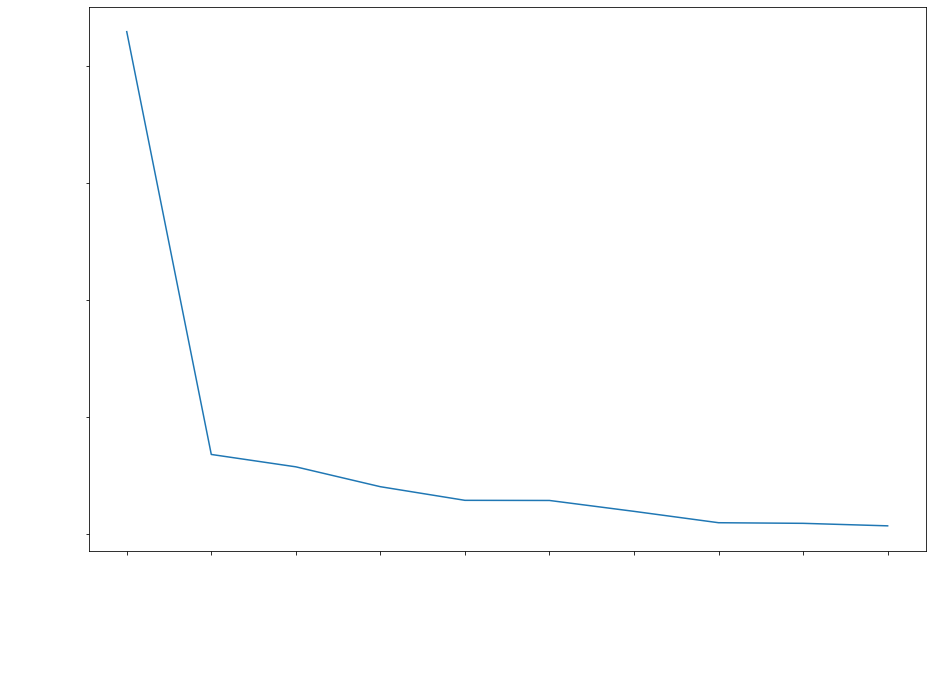

In [ ]:
plt.figure(figsize=(15,10))
y=[ImportanceScores[x] for x in MostImportant]
fig=plt.plot(MostImportant,y)
plt.xticks(rotation=90,fontsize=18,color='w')
plt.yticks(fontsize=18,color='w')
plt.xlabel("Important Feature",fontsize=20,color='w')
plt.ylabel("Importance Score",fontsize=20,color='w')
plt.show("mostImportant.jpg")

## Finding which features each important feature depends  
For each of these "important features", it is possible that there exists another feature or set of features that, when used with the important feature to train a model, increases its accuracy, i.e the “importance” of this  feature may depend on another feature or set of features. 

For each of the above mentioned 10 most “important” features, the below procedure was followed:

1) Of the 10,000 total groupings, select only those groupings that contain the important feature currently being considered.

2) Make a list of the set of unique features included in these groupings and remove the important feature currently being considered. 

3) For each of the features in the resultant list, calculate the sum of the model accuracies  for the groupings where that feature is present and divide this sum by the frequency of that feature. This will act as a "trend score" to tell us how important this feature is to the accuracy of our model when a particular "important feature" is being considered. 


In [ ]:
#Number of trend features to find for each important feature
numTrends=10

"""Structure of trends dict:
trends -> MostIMportant Feature-> dict of feature -> [sum of scores, count]"""
trends={}


def addFeats(features,score,impFeat):
    """Add feature to trends dict under the impFeat key"""
    global trends
    for n in features:
        if n!=impFeat:
            try:
                trends[impFeat][n][0]+=score
                trends[impFeat][n][1]+=1
            except:
                trends[impFeat][n]=[score,1]

#Create an empty dict in trends as a value for each feature in MostImportant 
for n in MostImportant:
    trends[n]={}

#Get the Trend scores for the MostImportant features using the data from the groupings with accuracy scores greater than 70%
for index,row in top.iterrows():
    features=[x.strip() for x in row.features.split(",") if ("err" not in x and "lim" not in x and x!='pl_st_nref' and x!='pl_locale' and x in trainCols)]
    for n in MostImportant:
        if n in features:
            addFeats(features,row.score,n)

#Keep only the numTrends number of trend features for each most important feature
for ImpFeat in trends.keys():
    for feat in trends[ImpFeat].keys():
        #Convert the [score, count] lists in trends dict to trend scores
        trends[ImpFeat][feat]=trends[ImpFeat][feat][0]/trends[ImpFeat][feat][1]
    
    #Get top trend features for each important feature
    trendBest=sorted(trends[ImpFeat],key=trends[ImpFeat].get)
    trendBest.reverse()
    trendBest=trendBest[:numTrends]
    
    #Keep only top "numTrends" number of features
    temp={}
    for feat in trendBest:
        temp[feat]=trends[ImpFeat][feat]
    trends[ImpFeat]=temp


### Results




#### **Important feature being considered: _pl_orbper_** 

Trend Feature: Trend Score

1. st_elon : Ecliptic Longitude [deg] : 0.7592035906461789
2. st_nspec : Number of Spectra : 0.7590521922133676
3. pl_ttvflag : TTV Flag : 0.7540637645331667
4. pl_omflag : Planet Orbital Modulation Flag : 0.7540431937924365
5. gaia_pmra : Gaia Proper Motion (RA) [mas/yr] : 0.753806935745678
6. st_pm : Total Proper Motion [mas/yr] : 0.7531459736759966
7. st_j : J-band (2MASS) [mag] : 0.7530924702836953
8. st_wise4 : WISE 22.um [mag] : 0.7527684530256562
9. gaia_gmag : G-band (Gaia) [mag] : 0.752167436346099
10. dec : Dec [decimal degrees] : 0.7521483342637123

#### **Important feature being considered: _st_pm_** 

Trend Feature: Trend Score

1. st_elon : Ecliptic Longitude [deg] : 0.7688514521109421
2. pl_omflag : Planet Orbital Modulation Flag : 0.7631389241615307
3. pl_ttvflag : TTV Flag : 0.7614209805781844
4. st_logg : Stellar Surface Gravity [log10(cm/s**2)] : 0.7601732526447382
5. pl_status : Status : 0.7593535024010405
6. st_colorn : Number of Color Measurements : 0.7584680831029883
7. pl_mnum : Number of Moons in System : 0.7583325548578497
8. pl_astflag : Planet Astrometry Flag : 0.7577441319135508
9. pl_rads : Planet Radius [Solar radii] : 0.7576930253339714
10. st_nglc : Number of General Light Curves : 0.7565930941421772

#### **Important feature being considered: _gaia_pm_** 

Trend Feature: Trend Score

1. pl_omflag : Planet Orbital Modulation Flag : 0.7557720785225056
2. st_nspec : Number of Spectra : 0.7545496731194764
3. gaia_pmra : Gaia Proper Motion (RA) [mas/yr] : 0.7545469568159392
4. pl_astflag : Planet Astrometry Flag : 0.7523404640927442
5. pl_rade : Planet Radius [Earth radii] : 0.7519950929108621
6. st_elon : Ecliptic Longitude [deg] : 0.750584405321416
7. st_hmk2 : H-Ks (2MASS) [mag] : 0.7503797070106375
8. st_nts : Number of Time Series : 0.7500371008065948
9. st_naxa : Number of Amateur Light Curves : 0.7498516324817481
10. pl_status : Status : 0.7495398589383278

#### **Important feature being considered: _gaia_pmra_** 

Trend Feature: Trend Score

1. pl_astflag : Planet Astrometry Flag : 0.7628407745266962
2. st_elon : Ecliptic Longitude [deg] : 0.7586857661552391
3. ra : RA [decimal degrees] : 0.7584354984190544
4. st_nspec : Number of Spectra : 0.7574350567376736
5. st_nplc : Number of Planet Transit Light Curves : 0.7574040862018674
6. pl_ttvflag : TTV Flag : 0.7571267845524186
7. pl_omflag : Planet Orbital Modulation Flag : 0.7561787786530486
8. st_nts : Number of Time Series : 0.7559556821962088
9. pl_rvflag : Planet RV Flag : 0.7556635631818472
10. gaia_gmag : G-band (Gaia) [mag] : 0.7556129252486619

#### **Important feature being considered: _st_pmra_** 

Trend Feature: Trend Score

1. st_nspec : Number of Spectra : 0.7537403775144983
2. pl_omflag : Planet Orbital Modulation Flag : 0.7510966780429872
3. st_rad : Stellar Radius [Solar radii] : 0.7501646690841334
4. st_glat : Galactic Latitude [deg] : 0.7494236578003195
5. pl_orbper : Orbital Period [days] : 0.7493236463705882
6. pl_rvflag : Planet RV Flag : 0.7487014682286942
7. st_wise4 : WISE 22.um [mag] : 0.7482207728832807
8. pl_ttvflag : TTV Flag : 0.7481008292376288
9. st_elon : Ecliptic Longitude [deg] : 0.7478450618764491
10. pl_rads : Planet Radius [Solar radii] : 0.7477585424062823

#### **Important feature being considered: _st_glon_** 

Trend Feature: Trend Score

1. pl_disc : Year of Discovery : 0.754541346152013
2. pl_omflag : Planet Orbital Modulation Flag : 0.7539861363565952
3. st_nspec : Number of Spectra : 0.7523368391534827
4. pl_rvflag : Planet RV Flag : 0.7522963254043785
5. gaia_pmra : Gaia Proper Motion (RA) [mas/yr] : 0.7513211449210165
6. pl_astflag : Planet Astrometry Flag : 0.751293402468329
7. pl_ttvflag : TTV Flag : 0.7510295193959647
8. pl_orbper : Orbital Period [days] : 0.7488256586300996
9. st_jmh2 : J-H (2MASS) [mag] : 0.748384937710367
10. st_nplc : Number of Planet Transit Light Curves : 0.7482826780749287

#### **Important feature being considered: _gaia_pmdec_** 

Trend Feature: Trend Score

1. gaia_gmag : G-band (Gaia) [mag] : 0.7528967293718828
2. pl_omflag : Planet Orbital Modulation Flag : 0.7525351890969558
3. st_wise4 : WISE 22.um [mag] : 0.7512603235312345
4. st_pmdec : Proper Motion (Dec) [mas/yr] : 0.7495674293948075
5. st_nrvc : Number of Radial Velocity Time Series : 0.7495292955850237
6. dec : Dec [decimal degrees] : 0.7492974064642902
7. pl_astflag : Planet Astrometry Flag : 0.7483747665354459
8. st_nspec : Number of Spectra : 0.7480934874791174
9. ra : RA [decimal degrees] : 0.7478021761080307
10. st_optmag : Optical Magnitude [mag] : 0.7477106774491494

#### **Important feature being considered: _st_elat_** 

Trend Feature: Trend Score

1. pl_mnum : Number of Moons in System : 0.759415471759915
2. pl_status : Status : 0.7586448492012665
3. st_logg : Stellar Surface Gravity [log10(cm/s**2)] : 0.7580615855298644
4. ra : RA [decimal degrees] : 0.7578375204749722
5. st_elon : Ecliptic Longitude [deg] : 0.7570157751961838
6. pl_rads : Planet Radius [Solar radii] : 0.7568401056991289
7. pl_ttvflag : TTV Flag : 0.756357612905094
8. st_nglc : Number of General Light Curves : 0.7547072856248129
9. st_naxa : Number of Amateur Light Curves : 0.7531015876066968
10. gaia_gmag : G-band (Gaia) [mag] : 0.7525728143580261

#### **Important feature being considered: _st_metfe_** 

Trend Feature: Trend Score

1. pl_rads : Planet Radius [Solar radii] : 0.7505923111749532
2. pl_omflag : Planet Orbital Modulation Flag : 0.7500374153377655
3. st_elat : Ecliptic Latitude [deg] : 0.7497747912331086
4. st_nglc : Number of General Light Curves : 0.7489087300174487
5. st_mass : Stellar Mass [Solar mass] : 0.7483859930498834
6. gaia_plx : Gaia Parallax [mas] : 0.74824059801986
7. st_elon : Ecliptic Longitude [deg] : 0.7474461001467446
8. pl_astflag : Planet Astrometry Flag : 0.7474388453311147
9. st_jmh2 : J-H (2MASS) [mag] : 0.7473774439873292
10. pl_ttvflag : TTV Flag : 0.7472838068220223

#### **Important feature being considered: _gaia_plx_** 

Trend Feature: Trend Score

1. pl_omflag : Planet Orbital Modulation Flag : 0.7597640250316207
2. pl_rads : Planet Radius [Solar radii] : 0.7559067601384624
3. st_glat : Galactic Latitude [deg] : 0.7534493886538781
4. st_elon : Ecliptic Longitude [deg] : 0.7527911734573259
5. pl_rvflag : Planet RV Flag : 0.752587547631023
6. pl_astflag : Planet Astrometry Flag : 0.7515863292747441
7. pl_status : Status : 0.7510807664488703
8. st_photn : Number of Photometry Measurements : 0.7507727570943497
9. st_colorn : Number of Color Measurements : 0.7505283186203643
10. pl_nnotes : Number of Notes : 0.7503698427180573



#### Visualtisation

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


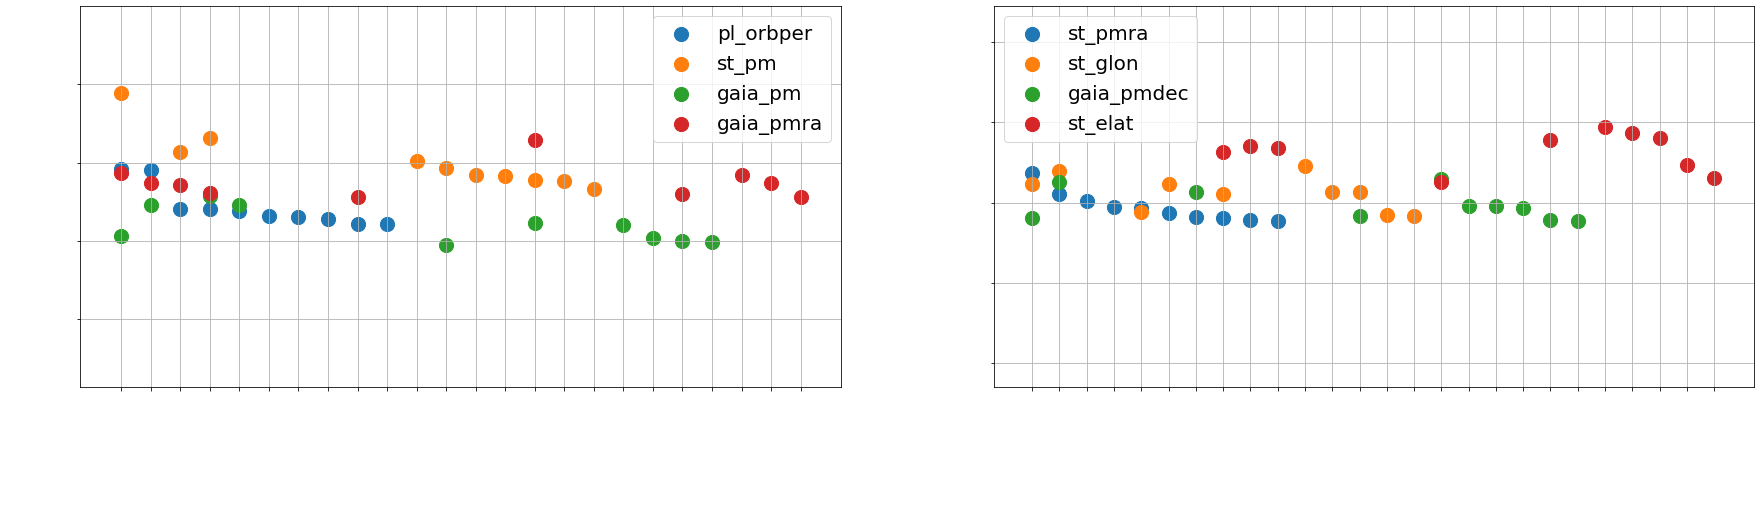

In [ ]:
#plot the trends of the top 8 most important features
#x axis represents the trend features 
#y axis represents the trends score
#color represents which important feature is being considered

fig=plt.figure(figsize=(30,7))
labels=MostImportant
axis=1
for n in labels[0:4]:
    ax=fig.add_subplot(1,2,1)
    x=list(trends[n].keys())
    y=[trends[n][feat] for feat in x]
    ax.scatter(x,y,marker=MarkerStyle(marker=".", fillstyle=None),s=800)
    plt.xlabel("Trend feature",fontsize=30,color='w')
    plt.ylabel("Trend score",fontsize=30,color='w')
    plt.xticks(rotation=90,fontsize=15,color='w')
    plt.yticks(fontsize=15,color='w')
plt.grid()
plt.legend(labels[0:4],prop={'size': 20})


for n in labels[4:8]:
    ax=fig.add_subplot(1,2,2)
    x=list(trends[n].keys())
    y=[trends[n][feat] for feat in x]
    ax.scatter(x,y,marker=MarkerStyle(marker=".", fillstyle=None),s=800)
    plt.xlabel("Trend feature",fontsize=30,color='w')
    plt.ylabel("Trend score",fontsize=30,color='w')
    plt.xticks(rotation=90,fontsize=15,color='w')
    plt.yticks(fontsize=15,color='w')
plt.grid()
plt.legend(labels[4:],prop={'size': 20})